# train

In [1]:
import yaml
import os

with open("./config.yaml", 'rb') as f:
    config = yaml.load(f)

<ipython-input-1-1499ab5789c7>:5: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [2]:
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
os.makedirs(OUTPUT_ROOT, exist_ok=True)

## load library

In [3]:
# python default library
import os
import shutil
import datetime
import sys
import pickle

# general analysis tool-kit
import numpy as np
import pandas as pd
#from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# pytorch
import torch
from torch import optim, nn
from torch.utils.tensorboard import SummaryWriter

#from torchsummary import summary

# etc
import yaml
yaml.warnings({'YAMLLoadWarning': False})

# original library
sys.path.append('/home/hiroki/research/dcase2021_task2/src/functions')
import common as com
import pytorch_modeler as modeler
from pytorch_model import Conditional_VAE as Model
#from pytorch_utils import filtered_load_model
#import models

import librosa
import IPython
import librosa.display

## load config and set logger

In [4]:
log_file = config['IO_OPTION']['OUTPUT_ROOT']+'/train_{0}.log'.format(datetime.date.today())
logger = com.setup_logger(log_file, '00_train.py')

## Setting

In [5]:
# Setting seed
modeler.set_seed(777)

In [6]:
############################################################################
# Setting I/O path
############################################################################
# input dirs
INPUT_ROOT = config['IO_OPTION']['INPUT_ROOT']
#dev_dir = INPUT_ROOT + "/dev_data"
#add_dev_dir = INPUT_ROOT + "/add_dev_data"
# machine type
machine_types = ['ToyCar', 'gearbox', 'valve', 'ToyTrain', 'pump', 'fan', 'slider']
# output dirs
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
MODEL_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/models'
TB_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/tb'
OUT_FEATURE_DIR = OUTPUT_ROOT + '/extraction_features'
OUT_SCORE_DIR = OUTPUT_ROOT + '/score'
OUT_PRED_DIR = OUTPUT_ROOT + '/pred'
#os.makedirs(OUTPUT_ROOT, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TB_DIR, exist_ok=True)
os.makedirs(OUT_FEATURE_DIR, exist_ok=True)
os.makedirs(OUT_SCORE_DIR, exist_ok=True)
os.makedirs(OUT_PRED_DIR, exist_ok=True)
# copy config
shutil.copy('./config.yaml', OUTPUT_ROOT)

'/media/hiroki/HDD1TB/research/dcase2021_task2/output/ID_Conditional_VAE/CVAE_ex4/config.yaml'

In [7]:
torch.cuda.is_available()

True

In [8]:
ext_data = pd.read_pickle(f'{INPUT_ROOT}/valve_features.pkl')

In [9]:
pd.DataFrame(ext_data['train']['features'])

,0,1,2,3,4,5,6,7,8,9,...,3062,3063,3064,3065,3066,3067,3068,3069,3070,3071
0,0.141376,0.126192,0.160170,0.039393,0.116594,0.244344,0.364260,0.179045,0.304383,0.316418,...,0.000000,0.000000,0.000000,0.0,0.011685,0.0,0.0,0.0,0.001349,0.024873
1,0.139377,0.119569,0.153211,0.039412,0.117448,0.268657,0.362977,0.172853,0.304429,0.321536,...,0.000558,0.000000,0.000185,0.0,0.019411,0.0,0.0,0.0,0.010698,0.031158
2,0.163800,0.184355,0.172159,0.027273,0.110422,0.169510,0.386510,0.206604,0.313434,0.314130,...,0.011560,0.000000,0.000000,0.0,0.038945,0.0,0.0,0.0,0.000000,0.005341
3,0.143226,0.131679,0.156749,0.038878,0.115537,0.241695,0.368068,0.185738,0.308175,0.316420,...,0.000000,0.000457,0.000000,0.0,0.005694,0.0,0.0,0.0,0.008102,0.020985
4,0.137737,0.123774,0.149359,0.042918,0.111843,0.259588,0.368717,0.180469,0.305680,0.309504,...,0.000000,0.000000,0.000000,0.0,0.018220,0.0,0.0,0.0,0.003810,0.032367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6013,0.116490,0.110039,0.161647,0.043416,0.096190,0.239978,0.371168,0.168759,0.329152,0.293912,...,0.000000,0.000000,0.000000,0.0,0.002287,0.0,0.0,0.0,0.000226,0.023715
6014,0.125852,0.120752,0.164564,0.039160,0.104617,0.234347,0.369856,0.180599,0.320280,0.302117,...,0.001283,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.001988,0.014878
6015,0.107534,0.116570,0.173803,0.039604,0.088328,0.213753,0.390930,0.170922,0.355653,0.284926,...,0.000713,0.026625,0.000000,0.0,0.009445,0.0,0.0,0.0,0.005314,0.000665
6016,0.123527,0.140547,0.164611,0.038327,0.096956,0.192954,0.382039,0.200973,0.332633,0.290760,...,0.002548,0.011003,0.000000,0.0,0.011084,0.0,0.0,0.0,0.004229,0.010059


## training

In [10]:
#############################################################################
# run
#############################################################################
def run(machine_type):
    com.tic()
    
    logger.info('TARGET MACHINE_TYPE: {0}'.format(machine_type))
    logger.info('MAKE DATA_LOADER')
    # dataloader
    ext_data = pd.read_pickle(f'{INPUT_ROOT}/{machine_type}_features.pkl')
    dataloaders_dict = modeler.make_dataloader(ext_data)
    # define writer for tensorbord
    os.makedirs(TB_DIR+'/'+machine_type, exist_ok=True)
    tb_log_dir = TB_DIR + '/' + machine_type
    writer = SummaryWriter(log_dir = tb_log_dir)
    # out path
    model_out_path = MODEL_DIR+'/{}_model.pth'.format(machine_type)
    score_out_path = OUT_SCORE_DIR + '/{}_score.csv'.format(machine_type)
    pred_out_path = OUT_PRED_DIR + '/{}_pred.csv'.format(machine_type)
    logger.info('TRAINING')
    # parameter setting
    in_features = ext_data['train']['features'].shape[1]
    mid_size = config['param']['mid_size']
    latent_size = config['param']['latent_size']
    num_classes = 6
    net = Model(in_features, mid_size, latent_size, num_classes)
    optimizer = optim.Adam(net.parameters(), lr=1e-3)
    num_epochs = config['param']['num_epochs']
    #scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e-2, 
    #                                          max_lr=1e-3, epochs=num_epochs, steps_per_epoch=len(dataloaders_dict['train']))
    # training
    output_dicts = modeler.train_net(net, dataloaders_dict, optimizer, num_epochs, writer, model_out_path, score_out_path, pred_out_path)
    
    com.toc()

In [11]:
machine_types

['ToyCar', 'gearbox', 'valve', 'ToyTrain', 'pump', 'fan', 'slider']

In [12]:
#for machine_type in machine_types:
#    run(machine_type)

2021-05-21 22:43:12,161 - 00_train.py - INFO - TARGET MACHINE_TYPE: valve
2021-05-21 22:43:12,161 - 00_train.py - INFO - MAKE DATA_LOADER
2021-05-21 22:43:12,203 - 00_train.py - INFO - TRAINING
2021-05-21 22:43:14,293 - pytorch_modeler.py - INFO - train
  0%|          | 0/12 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 12/12 [00:01<00:00, 10.82it/s]
2021-05-21 22:43:15,405 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.67it/s]
2021-05-21 22:43:15,620 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.50it/s]


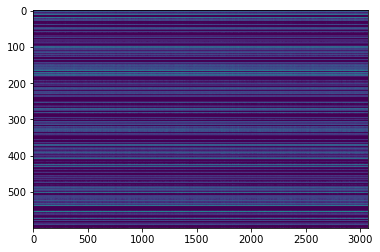

,AUC,pAUC
Source_0,0.426600,0.537368
Source_1,0.473100,0.510000
Source_2,0.516700,0.500526
Target_0,0.440300,0.498421
Target_1,0.508100,0.562632
Target_2,0.406700,0.503158
mean,0.461917,0.518684
h_mean,0.458320,0.517654


2021-05-21 22:43:16,806 - pytorch_modeler.py - INFO - epoch:1/300, train_losses:1000.246353, val_AUC_hmean:0.458320, val_pAUC_hmean:0.517654, best_flag:True
2021-05-21 22:43:16,807 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.52it/s]
2021-05-21 22:43:17,262 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.12it/s]
2021-05-21 22:43:17,471 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  9.52it/s]


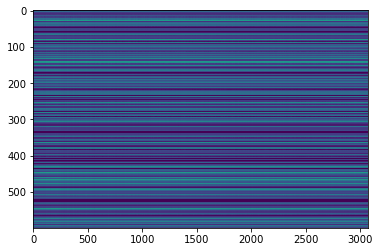

,AUC,pAUC
Source_0,0.431400,0.512105
Source_1,0.417000,0.507895
Source_2,0.603500,0.506842
Target_0,0.446800,0.497368
Target_1,0.571400,0.593158
Target_2,0.477800,0.519474
mean,0.491317,0.522807
h_mean,0.481763,0.521008


2021-05-21 22:43:18,527 - pytorch_modeler.py - INFO - epoch:2/300, train_losses:648.926559, val_AUC_hmean:0.481763, val_pAUC_hmean:0.521008, best_flag:True
2021-05-21 22:43:18,528 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.17it/s]
2021-05-21 22:43:18,989 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.36it/s]
2021-05-21 22:43:19,191 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.46it/s]
2021-05-21 22:43:19,391 - pytorch_modeler.py - INFO - epoch:3/300, train_losses:575.032633, val_AUC_hmean:0.375662, val_pAUC_hmean:0.500232, best_flag:False
2021-05-21 22:43:19,392 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.85it/s]
2021-05-21 22:43:19,859 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.53it/s]
2021-05-21 22:43:20,072 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.71it/s]


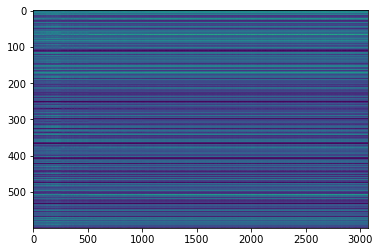

,AUC,pAUC
Source_0,0.527500,0.511053
Source_1,0.468000,0.518947
Source_2,0.583500,0.532632
Target_0,0.526900,0.538421
Target_1,0.652700,0.611053
Target_2,0.447500,0.489474
mean,0.534350,0.533596
h_mean,0.525813,0.531067


2021-05-21 22:43:21,100 - pytorch_modeler.py - INFO - epoch:4/300, train_losses:533.215719, val_AUC_hmean:0.525813, val_pAUC_hmean:0.531067, best_flag:True
2021-05-21 22:43:21,101 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.15it/s]
2021-05-21 22:43:21,562 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.87it/s]
2021-05-21 22:43:21,786 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.79it/s]


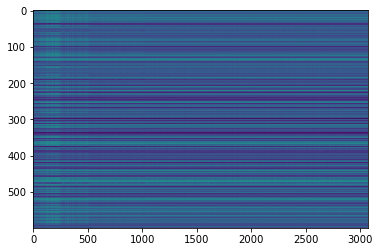

,AUC,pAUC
Source_0,0.628000,0.507368
Source_1,0.499100,0.488947
Source_2,0.720500,0.562105
Target_0,0.513300,0.521579
Target_1,0.617900,0.562632
Target_2,0.498500,0.493684
mean,0.579550,0.522719
h_mean,0.568372,0.521042


2021-05-21 22:43:22,818 - pytorch_modeler.py - INFO - epoch:5/300, train_losses:510.238625, val_AUC_hmean:0.568372, val_pAUC_hmean:0.521042, best_flag:True
2021-05-21 22:43:22,820 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.12it/s]
2021-05-21 22:43:23,281 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.89it/s]
2021-05-21 22:43:23,488 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.58it/s]


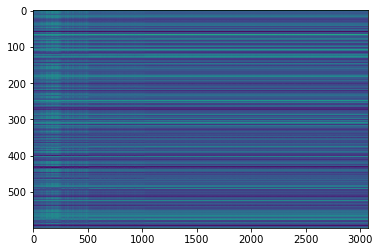

,AUC,pAUC
Source_0,0.616300,0.482632
Source_1,0.467900,0.479474
Source_2,0.779500,0.616316
Target_0,0.591700,0.556316
Target_1,0.602200,0.582105
Target_2,0.540700,0.497368
mean,0.599717,0.535702
h_mean,0.585780,0.530684


2021-05-21 22:43:24,667 - pytorch_modeler.py - INFO - epoch:6/300, train_losses:491.305555, val_AUC_hmean:0.585780, val_pAUC_hmean:0.530684, best_flag:True
2021-05-21 22:43:24,668 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.79it/s]
2021-05-21 22:43:25,155 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.53it/s]
2021-05-21 22:43:25,369 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.14it/s]
2021-05-21 22:43:25,576 - pytorch_modeler.py - INFO - epoch:7/300, train_losses:471.521690, val_AUC_hmean:0.560792, val_pAUC_hmean:0.526105, best_flag:False
2021-05-21 22:43:25,577 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.45it/s]
2021-05-21 22:43:26,051 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.03it/s]
2021-05-21 22:43:26,256 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.10it/s]
2021-05-21 22:43:26

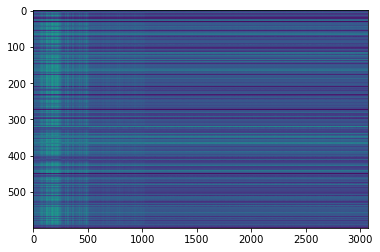

,AUC,pAUC
Source_0,0.668400,0.496842
Source_1,0.527300,0.487368
Source_2,0.773300,0.672105
Target_0,0.625600,0.532105
Target_1,0.600300,0.569474
Target_2,0.562900,0.495263
mean,0.626300,0.542193
h_mean,0.616869,0.535386


2021-05-21 22:43:28,317 - pytorch_modeler.py - INFO - epoch:9/300, train_losses:450.540293, val_AUC_hmean:0.616869, val_pAUC_hmean:0.535386, best_flag:True
2021-05-21 22:43:28,318 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.26it/s]
2021-05-21 22:43:28,795 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.78it/s]
2021-05-21 22:43:29,005 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.71it/s]
2021-05-21 22:43:29,218 - pytorch_modeler.py - INFO - epoch:10/300, train_losses:440.966672, val_AUC_hmean:0.584095, val_pAUC_hmean:0.532334, best_flag:False
2021-05-21 22:43:29,219 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.90it/s]
2021-05-21 22:43:29,704 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  7.64it/s]
2021-05-21 22:43:29,989 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.74it/s]


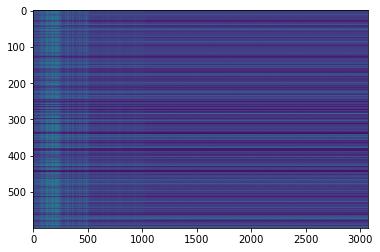

,AUC,pAUC
Source_0,0.653200,0.521579
Source_1,0.579400,0.516316
Source_2,0.749000,0.612105
Target_0,0.742100,0.580526
Target_1,0.606500,0.597368
Target_2,0.533400,0.502105
mean,0.643933,0.555000
h_mean,0.634044,0.551676


2021-05-21 22:43:31,069 - pytorch_modeler.py - INFO - epoch:11/300, train_losses:429.670250, val_AUC_hmean:0.634044, val_pAUC_hmean:0.551676, best_flag:True
2021-05-21 22:43:31,070 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.64it/s]
2021-05-21 22:43:31,540 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.29it/s]
2021-05-21 22:43:31,756 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.53it/s]
2021-05-21 22:43:31,959 - pytorch_modeler.py - INFO - epoch:12/300, train_losses:418.362681, val_AUC_hmean:0.567020, val_pAUC_hmean:0.545593, best_flag:False
2021-05-21 22:43:31,960 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.23it/s]
2021-05-21 22:43:32,420 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.77it/s]
2021-05-21 22:43:32,630 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.19it/s]
2021-05-21 22:43:

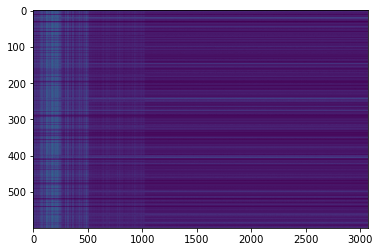

,AUC,pAUC
Source_0,0.728400,0.567895
Source_1,0.634800,0.555263
Source_2,0.772100,0.678947
Target_0,0.699400,0.614211
Target_1,0.611200,0.592105
Target_2,0.496900,0.488947
mean,0.657133,0.582895
h_mean,0.643657,0.577094


2021-05-21 22:43:37,145 - pytorch_modeler.py - INFO - epoch:17/300, train_losses:372.888568, val_AUC_hmean:0.643657, val_pAUC_hmean:0.577094, best_flag:True
2021-05-21 22:43:37,146 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.02it/s]
2021-05-21 22:43:37,610 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.29it/s]
2021-05-21 22:43:37,809 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.22it/s]


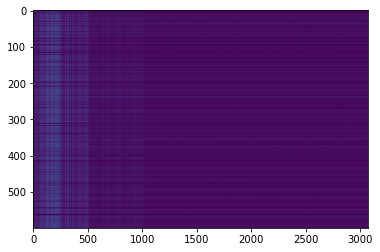

,AUC,pAUC
Source_0,0.696900,0.558947
Source_1,0.613700,0.554211
Source_2,0.770000,0.676316
Target_0,0.672000,0.606842
Target_1,0.594400,0.587895
Target_2,0.559900,0.492632
mean,0.651150,0.579474
h_mean,0.643805,0.574118


2021-05-21 22:43:38,804 - pytorch_modeler.py - INFO - epoch:18/300, train_losses:366.223778, val_AUC_hmean:0.643805, val_pAUC_hmean:0.574118, best_flag:True
2021-05-21 22:43:38,805 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.31it/s]
2021-05-21 22:43:39,263 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.01it/s]
2021-05-21 22:43:39,468 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.46it/s]
2021-05-21 22:43:39,668 - pytorch_modeler.py - INFO - epoch:19/300, train_losses:357.851766, val_AUC_hmean:0.609768, val_pAUC_hmean:0.568183, best_flag:False
2021-05-21 22:43:39,669 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.33it/s]
2021-05-21 22:43:40,127 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.81it/s]
2021-05-21 22:43:40,337 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.36it/s]
2021-05-21 22:43:

100%|██████████| 2/2 [00:00<00:00, 10.99it/s]
2021-05-21 22:43:53,900 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.55it/s]
2021-05-21 22:43:54,099 - pytorch_modeler.py - INFO - epoch:35/300, train_losses:262.409566, val_AUC_hmean:0.600809, val_pAUC_hmean:0.568403, best_flag:False
2021-05-21 22:43:54,101 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.55it/s]
2021-05-21 22:43:54,556 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.91it/s]
2021-05-21 22:43:54,763 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.85it/s]
2021-05-21 22:43:54,978 - pytorch_modeler.py - INFO - epoch:36/300, train_losses:257.362144, val_AUC_hmean:0.618579, val_pAUC_hmean:0.567220, best_flag:False
2021-05-21 22:43:54,980 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.61it/s]
2021-05-21 22:43:55,433 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

100%|██████████| 12/12 [00:00<00:00, 25.46it/s]
2021-05-21 22:44:09,213 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.32it/s]
2021-05-21 22:44:09,412 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.70it/s]
2021-05-21 22:44:09,626 - pytorch_modeler.py - INFO - epoch:52/300, train_losses:190.730403, val_AUC_hmean:0.580644, val_pAUC_hmean:0.566867, best_flag:False
2021-05-21 22:44:09,627 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.83it/s]
2021-05-21 22:44:10,096 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.18it/s]
2021-05-21 22:44:10,297 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.05it/s]
2021-05-21 22:44:10,504 - pytorch_modeler.py - INFO - epoch:53/300, train_losses:187.373520, val_AUC_hmean:0.581886, val_pAUC_hmean:0.565633, best_flag:False
2021-05-21 22:44:10,506 - pytorch_modeler.py - INFO - train
100%|██████████|

2021-05-21 22:44:23,989 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.30it/s]
2021-05-21 22:44:24,471 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.35it/s]
2021-05-21 22:44:24,669 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.29it/s]
2021-05-21 22:44:24,874 - pytorch_modeler.py - INFO - epoch:69/300, train_losses:138.778901, val_AUC_hmean:0.592500, val_pAUC_hmean:0.571739, best_flag:False
2021-05-21 22:44:24,875 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.42it/s]
2021-05-21 22:44:25,331 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.20it/s]
2021-05-21 22:44:25,531 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.04it/s]
2021-05-21 22:44:25,737 - pytorch_modeler.py - INFO - epoch:70/300, train_losses:136.678733, val_AUC_hmean:0.583567, val_pAUC_hmean:0.570251, best_flag:False
2021-05-21 22:44

100%|██████████| 2/2 [00:00<00:00, 10.72it/s]
2021-05-21 22:44:39,001 - pytorch_modeler.py - INFO - epoch:85/300, train_losses:103.116275, val_AUC_hmean:0.573072, val_pAUC_hmean:0.565803, best_flag:False
2021-05-21 22:44:39,002 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.89it/s]
2021-05-21 22:44:39,468 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.27it/s]
2021-05-21 22:44:39,666 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.22it/s]
2021-05-21 22:44:39,869 - pytorch_modeler.py - INFO - epoch:86/300, train_losses:101.021561, val_AUC_hmean:0.593155, val_pAUC_hmean:0.563359, best_flag:False
2021-05-21 22:44:39,870 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.06it/s]
2021-05-21 22:44:40,333 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.96it/s]
2021-05-21 22:44:40,540 - pytorch_modeler.py - INFO - valid_target
100%|██████████|

100%|██████████| 2/2 [00:00<00:00, 10.76it/s]
2021-05-21 22:44:53,960 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.99it/s]
2021-05-21 22:44:54,168 - pytorch_modeler.py - INFO - epoch:102/300, train_losses:75.393201, val_AUC_hmean:0.582462, val_pAUC_hmean:0.559461, best_flag:False
2021-05-21 22:44:54,169 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.29it/s]
2021-05-21 22:44:54,667 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.09it/s]
2021-05-21 22:44:54,910 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.51it/s]
2021-05-21 22:44:55,128 - pytorch_modeler.py - INFO - epoch:103/300, train_losses:73.719837, val_AUC_hmean:0.584118, val_pAUC_hmean:0.560789, best_flag:False
2021-05-21 22:44:55,129 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.00it/s]
2021-05-21 22:44:55,611 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

100%|██████████| 12/12 [00:00<00:00, 25.87it/s]
2021-05-21 22:45:09,088 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.58it/s]
2021-05-21 22:45:09,302 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  9.49it/s]
2021-05-21 22:45:09,538 - pytorch_modeler.py - INFO - epoch:119/300, train_losses:54.448499, val_AUC_hmean:0.572935, val_pAUC_hmean:0.568181, best_flag:False
2021-05-21 22:45:09,540 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.36it/s]
2021-05-21 22:45:10,016 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.57it/s]
2021-05-21 22:45:10,230 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.24it/s]
2021-05-21 22:45:10,435 - pytorch_modeler.py - INFO - epoch:120/300, train_losses:53.541243, val_AUC_hmean:0.597574, val_pAUC_hmean:0.567311, best_flag:False
2021-05-21 22:45:10,436 - pytorch_modeler.py - INFO - train
100%|██████████|

2021-05-21 22:45:24,355 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.89it/s]
2021-05-21 22:45:24,821 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.88it/s]
2021-05-21 22:45:25,028 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.94it/s]
2021-05-21 22:45:25,236 - pytorch_modeler.py - INFO - epoch:136/300, train_losses:39.092996, val_AUC_hmean:0.594051, val_pAUC_hmean:0.566399, best_flag:False
2021-05-21 22:45:25,237 - pytorch_modeler.py - INFO - train
  8%|▊         | 1/12 [00:00<00:02,  4.17it/s]


KeyboardInterrupt: 

In [13]:
run(machine_types[2])